In [0]:
%tensorflow_version 2.x

In [0]:
import random
import numpy as np
import skimage.filters
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

%matplotlib inline

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11493376/11490434 [==============================] - 0s 0us/step


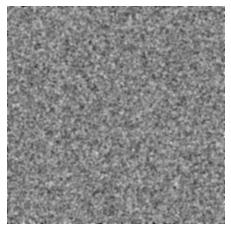

In [4]:
# Подготовка фона для новых изображений
bg_source = np.random.rand(1000, 1000, 1).astype(np.float32)
bg_source = skimage.filters.gaussian(bg_source, 4)
bg_source = (bg_source - np.min(bg_source)) / (np.max(bg_source) - np.min(bg_source))
bg_source = np.clip(bg_source, 0, 1) # обрезает min и max

plt.imshow(bg_source[..., 0], cmap='gray')
plt.axis('off')
plt.show()

In [0]:
# Функция для конвертации MNIST в датасет для локализации
def convert_to_loc_ds(x, y, bg_source, new_size=(64, 64)):
    x_new = np.zeros((x.shape[0], new_size[0], new_size[1], 1), dtype=np.float32)
    y_new = np.zeros((y.shape[0], 10, 5), dtype=np.float32) 
    # 10 классов, 4 координаты + вероятность класса
    y_new[:, :, 1:] = -1

    rh = float(x.shape[1]) / new_size[0] # 28/64
    rw = float(x.shape[2]) / new_size[1]

    for i in range(x.shape[0]):
        oh = random.randint(0, bg_source.shape[0] - new_size[0])
        ow = random.randint(0, bg_source.shape[1] - new_size[1])
        x_new[i] = bg_source[oh:oh+new_size[0], ow:ow+new_size[1], :]
        # выбрали кусок
        oh = random.randint(0, x_new[i, ...].shape[0] - x[i].shape[0])
        ow = random.randint(0, x_new[i, ...].shape[1] - x[i].shape[1])
        x_new[i, oh:oh+x[i].shape[0], ow:ow+x[i].shape[1], :] += x[i]
        # добавили изображение
        x_new[i] = np.clip(x_new[i], 0, 1)
        ry = float(oh) / new_size[0]
        rx = float(ow) / new_size[1]        
        y_new[i][y[i]] = [1., ry, rx, rh, rw] # 1. - вероятность класса

    return x_new, y_new


In [6]:
new_size = (64, 64)

train_x_new, train_y_new = convert_to_loc_ds(train_x, train_y, bg_source, new_size)
test_x_new, test_y_new = convert_to_loc_ds(test_x, test_y, bg_source, new_size)

print(train_x_new.shape)
print(train_y_new.shape)
print(test_x_new.shape)
print(test_y_new.shape)

(60000, 64, 64, 1)
(60000, 10, 5)
(10000, 64, 64, 1)
(10000, 10, 5)


In [0]:
# Функция для визуализации локализации
def show_prediction(x, logits): # logits 10x5
    pred_cls = np.argmax(logits[:, 0])
    ry, rx, rh, rw = logits[pred_cls][1:]

    box_y = round(ry * x.shape[0])
    box_x = round(rx * x.shape[1])
    box_h = round(rh * x.shape[0])
    box_w = round(rw * x.shape[1])  

    fig, ax = plt.subplots(1) 
    ax.imshow(x[..., 0], cmap='gray', vmin=0, vmax=1)
    rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1, edgecolor='red', fill=False)
    # facecolor=None
    ax.add_patch(rect)
    ax.axis('off')
    print('Prediction: {}'.format(pred_cls))
    print('Box: {}'.format((box_x, box_y, box_w, box_h)))

Prediction: 2
Box: (27.0, 8.0, 28.0, 28.0)


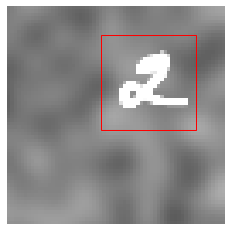

In [16]:
# Визуализация Ground=Truth образца
i = random.randint(0, train_x_new.shape[0])
show_prediction(train_x_new[i], train_y_new[i])

In [0]:
# Создание модели для классификации и локализации
class Model(tf.keras.Model):

    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation=tf.nn.relu, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation=tf.nn.relu, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(128, (5, 5), activation=tf.nn.relu, padding='same')
        self.conv4 = tf.keras.layers.Conv2D(128, (5, 5), activation=tf.nn.relu, padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(5*10, activation=None) # матрица 10х5
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
        self.flatten = tf.keras.layers.Flatten()

    def call(self, inp):
        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)       
        out = self.conv3(out)
        out = self.max_pool(out)   
        out = self.conv4(out)
        out = self.max_pool(out)         
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        # 50 чисел на выходе преобразуем в матрицу 10х5:
        out = tf.reshape(out, (-1, out.shape[1]//5, 5))

        return out

model = Model()

In [0]:
# Функция потерь (Loss)
def loss_cla(labels, logits):
    logits_cls = logits[:, :, 0] # вероятность
    labels_cls = labels[:, :, 0]
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        labels_cls, logits_cls, from_logits=True))
    
def loss_box(labels, logits):
    logits_box = logits[:, :, 1:] # бокс
    labels_box = labels[:, :, 1:]
    return tf.reduce_mean(tf.keras.losses.MSE(
        labels_box, logits_box))
    
LAMBDA = 10.
def loss_composit(labels, logits):
    return loss_cla(labels, logits) + LAMBDA * loss_box(labels, logits)

In [11]:
NUM_EPOCHS = 20
BATCH_SIZE = 64

model.compile(optimizer='adam', loss=loss_composit)
# метрика: Intersection over Union

hist = model.fit(train_x_new, train_y_new, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

Epoch 1/20
938/938 [==============================] - 19s 21ms/step - loss: 3.0571
Epoch 2/20
938/938 [==============================] - 19s 20ms/step - loss: 0.3524
Epoch 3/20
938/938 [==============================] - 19s 20ms/step - loss: 0.1777
Epoch 4/20
938/938 [==============================] - 19s 21ms/step - loss: 0.1207
Epoch 5/20
938/938 [==============================] - 19s 20ms/step - loss: 0.0930
Epoch 6/20
938/938 [==============================] - 19s 20ms/step - loss: 0.0680
Epoch 7/20
938/938 [==============================] - 19s 20ms/step - loss: 0.0576
Epoch 8/20
938/938 [==============================] - 19s 20ms/step - loss: 0.0491
Epoch 9/20
938/938 [==============================] - 19s 20ms/step - loss: 0.0432
Epoch 10/20
938/938 [==============================] - 19s 20ms/step - loss: 0.0324
Epoch 11/20
938/938 [==============================] - 19s 21ms/step - loss: 0.0258
Epoch 12/20
938/938 [==============================] - 19s 20ms/step - loss: 0.0350
E

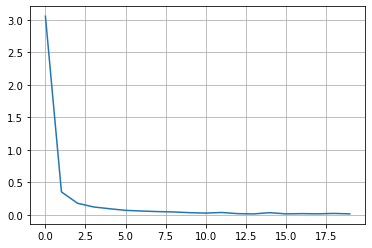

In [12]:
plt.plot(hist.history['loss'])
plt.grid(True)
plt.show()

Prediction: 1
Box: (-0.0, 12.0, 22.0, 22.0)


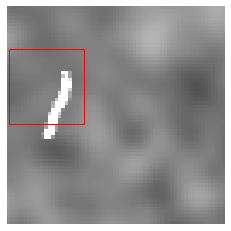

In [19]:
# Тестирование модели
# Визуализация Ground=Truth образца
i = random.randint(0, test_x_new.shape[0])
sample = test_x_new[i]

pred = model.predict(sample[None, ...])[0, ...]
show_prediction(sample, pred)